# Vehicle Sales Price Predictions Workshop - Part 2 of 3

## Training Pipeline

In order to make a machine learning system from this dataset, we have structured the service into 3 pipelines:

1. feature engineering pipeline notebook (see Part 1)
2. training pipeline notebook (ie. this Part 2)
3. inferencing pipeline notebook (see Part 3)

This notebook will outline the second step, ie. the training pipeline.


## <span style="color:#ff5f27">📝 Imports </span>

In [1]:
# Install XGBoost
!pip install xgboost -q

# Install the Hopsworks client library
!pip install --quiet hopsworks

In [2]:
import os
import time
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#ff5f27"> 📡 Connecting to Hopsworks Feature Store </span>

In [3]:
# Connect to the Hopsworks Feature store and get the feature group
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

car_prices_fg = fs.get_feature_group(
    name="car_prices", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/14457
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [4]:
# Create a feature view for the training
feature_view = fs.get_or_create_feature_view(
    name="car_prices",
    version=1,
    query= car_prices_fg.select_except(["seller", "saledate"]),
    labels=["sellingprice"],
)

## <span style="color:#ff5f27">👩🏻‍🍳 Data Preparation </span>

A machine learning model is a mathematical equation. An equation cannot accept anything other than numbers. Your categorical data must therefore be transformed (encoded) into numerical data at this stage. However, if you encode the data, you must also save the encoder for later decoding once the model is trained.

In [5]:
features_df, labels_df = feature_view.training_data()
labels_df
features_df

Finished: Reading data from Hopsworks, using ArrowFlight (2.30s) 


,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2011,Toyota,Prius,Three,Hatchback,automatic,43.0,38831.0,silver,gray
1,2014,Ram,1500,Tradesman,quad cab,automatic,45.0,5537.0,red,gray
2,1999,Ford,Mustang,Base,convertible,manual,39.0,58778.0,black,black
3,2005,Chevrolet,Malibu,Base,Sedan,automatic,34.0,126311.0,gold,gray
4,2009,Chevrolet,Impala,LT,sedan,automatic,32.0,116514.0,black,black
...,...,...,...,...,...,...,...,...,...,...
70214,2011,Toyota,4Runner,SR5,SUV,automatic,35.0,41837.0,black,beige
70215,2001,Toyota,Corolla,CE,Sedan,manual,29.0,202049.0,red,beige
70216,2007,Subaru,Outback,2.5i,Wagon,automatic,28.0,90686.0,white,tan
70217,2005,Mazda,Mazda6,i,Sedan,automatic,25.0,161647.0,white,tan


In [6]:
# Now we will encode the dataset
def encode_categorical_data(dataset, label_encoders):
    # Iterate over the columns of the DataFrame
    for column in dataset.columns:
        # Check if the column is of type 'object' (categorical)
        if dataset[column].dtype == 'object':
            # Create a LabelEncoder instance
            label_encoder = LabelEncoder()

            # Perform encoding on unique column values
            dataset[column] = label_encoder.fit_transform(dataset[column])

            # Add the encoder label to the dictionary
            label_encoders[column] = label_encoder
    return dataset

# Create a dictionary to store label encoders
clf = {}
df_encoded = encode_categorical_data(features_df, clf)
df_encoded

,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2011,45,435,1016,21,0,43.0,38831.0,15,6
1,2014,38,1,1027,66,0,45.0,5537.0,14,6
2,1999,12,406,321,43,1,39.0,58778.0,1,1
3,2005,7,373,321,32,0,34.0,126311.0,6,6
4,2009,7,308,657,69,0,32.0,116514.0,1,1
...,...,...,...,...,...,...,...,...,...,...
70214,2011,45,19,930,31,0,35.0,41837.0,1,0
70215,2001,45,149,369,32,1,29.0,202049.0,14,0
70216,2007,42,419,112,38,0,28.0,90686.0,17,13
70217,2005,29,386,1189,32,0,25.0,161647.0,17,13


Transform categorical values ​​from dataset 'dataset_cleaned.csv' into numeric values ​​and saves the encoder to a file for later use during prediction.

Cut the encoded dataset into two parts, train and test Keep 1000 data in the test dataset`

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, labels_df, test_size=1000, random_state=42)

# Show training and test set sizes
print("⛳️ Size of the training dataset :", len(X_train))
print("⛳️ Size of the test dataset :", len(X_test))

⛳️ Size of the training dataset : 69219
⛳️ Size of the test dataset : 1000


## <span style="color:#ff5f27">🏃🏻‍♂️ Model Training </span>


In [8]:
# Train the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1,
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 10583174.46598296


In [10]:
MODEL_NAME = "car_prices_model"

# Save the model as a JSON file
model.save_model(MODEL_NAME + '/xgboost_model.json')
joblib.dump(clf, MODEL_NAME + '/label_encoders.pkl')

['car_prices_model/label_encoders.pkl']

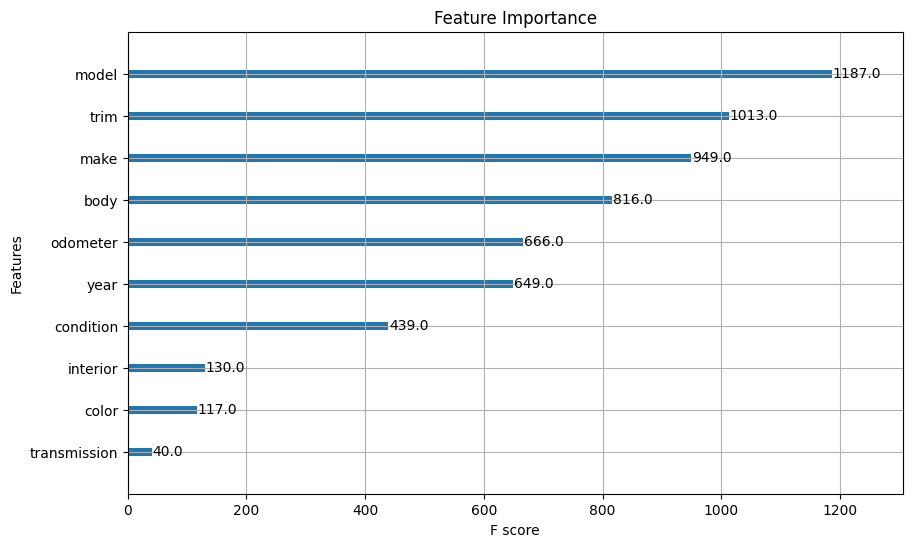

In [11]:
# Feature importance plot
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax)
plt.title('Feature Importance')

os.makedirs(MODEL_NAME + "/images", exist_ok=True)
plt.savefig(MODEL_NAME + '/images/feature_importance.png')

plt.show()

## <span style="color:#ff5f27">📝 Model Registry</span>


Sauvegarde le modèle entier entraîné dans un fichier pour l'utiliser après et le mettre en production

In [12]:
# This step will upload the model to the Hopsworks Model Registry
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features_df)
output_schema = Schema(labels_df)

model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

In [13]:
mr = project.get_model_registry()

car_prices_model = mr.python.create_model(
    MODEL_NAME,
    description="Car Price Predictor",
    input_example=X_train.sample(), 
    model_schema=model_schema,
    metrics={'test_loss': mse},
)

# Save the created model in the "car_prices_model" directory
car_prices_model.save(MODEL_NAME)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://snurran.hops.works/p/14457/models/car_prices_model/1


Model(name: 'car_prices_model', version: 1)

## <span style="color:#ff5f27">🚀 Model Deployment</span>


### <span style="color:#ff5f27">📎 Predictor script for Python models</span>


In [14]:
%%writefile predict_example.py
import os
import numpy as np
import hsfs
import joblib
import xgboost as xgb

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # Get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()

        # Load the model from the JSON file
        self.model = xgb.XGBRegressor()
        self.model.load_model(os.environ["ARTIFACT_FILES_PATH"] + "/xgboost_model.json")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(inputs).tolist()


Overwriting predict_example.py


In [15]:
# Get the dataset API for the current project
dataset_api = project.get_dataset_api()

# Specify the local file path of the Python script to be uploaded
local_script_path = "predict_example.py"

# Upload the Python script to the "Models", and overwrite if it already exists
uploaded_file_path = dataset_api.upload(local_script_path, "Models", overwrite=True)

# Create the full path to the uploaded script for future reference
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

### <span style="color:#ff5f27">⚙️ Create the deployment</span>


In [16]:
# Deploy the fraud model
deployment = car_prices_model.deploy(
    name="carpricemodeldeployment",  # Specify a name for the deployment
    script_file=predictor_script_path,  # Provide the path to the Python script for prediction
)

Deployment created, explore it at https://snurran.hops.works/p/14457/deployments/10266
Before making predictions, start the deployment by using `.start()`


In [17]:
# Print the name of the deployment
print("Deployment: " + deployment.name)

# Display information about the deployment
deployment.describe()

Deployment: carpricemodeldeployment
{
    "artifact_version": 1,
    "batching_configuration": {
        "batching_enabled": false
    },
    "created": "2024-06-26T12:51:30.228Z",
    "creator": "Maksym Zhytnikov",
    "description": null,
    "id": 10266,
    "inference_logging": "NONE",
    "model_framework": "PYTHON",
    "model_name": "car_prices_model",
    "model_path": "/Projects/Car_Price_Prediction/Models/car_prices_model",
    "model_server": "PYTHON",
    "model_version": 1,
    "name": "carpricemodeldeployment",
    "predictor": "predict_example.py",
    "predictor_resources": {
        "limits": {
            "cores": 1.0,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 0.2,
            "gpus": 0,
            "memory": 32
        }
    },
    "requested_instances": 0,
    "serving_tool": "KSERVE"
}


In [18]:
print("Deployment is warming up...")
time.sleep(15)

Deployment is warming up...


#### The deployment has now been registered. However, to start it you need to run the following command:

In [19]:
# Start the deployment and wait for it to be in a running state for up to 300 seconds
deployment.start(await_running=300)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [20]:
# Get the current state of the deployment
deployment.get_state().describe()

{
    "available_instances": 1,
    "available_transformer_instances": 0,
    "condition": {
        "reason": "Deployment is ready",
        "status": true,
        "type": "READY"
    },
    "deployed": "2024-06-26T12:51:46.000Z",
    "hopsworks_inference_path": "/project/14457/inference/models/carpricemodeldeployment",
    "model_server_inference_path": "/v1/models/carpricemodeldeployment",
    "revision": "38356770",
    "status": "Running"
}


In [21]:
# To troubleshoot you can use `get_logs()` method
deployment.get_logs(component='predictor')

Explore all the logs and filters in the Kibana logs at https://snurran.hops.works/p/14457/deployments/10266

Instance name: carpricemodeldeployment-predictor-default-00001-deploymentk9p6g
2024-06-26 10:51:50.373 7 root INFO [<module>():180] Loading serving script
2024-06-26 10:51:51.300 7 root INFO [__init__():95] Initializing predictor for deployment: carpricemodeldeployment
2024-06-26 10:51:51.503 7 root INFO [<module>():196] Starting KServe server
2024-06-26 10:51:51.503 7 root INFO [register_model():187] Registering model: carpricemodeldeployment
2024-06-26 10:51:51.504 7 root INFO [start():129] Setting max asyncio worker threads as 32
2024-06-26 10:51:51.504 7 root INFO [serve():139] Starting uvicorn with 1 workers
2024-06-26 10:51:51.519 7 uvicorn.error INFO [serve():84] Started server process [7]
2024-06-26 10:51:51.519 7 uvicorn.error INFO [startup():45] Waiting for application startup.
2024-06-26 10:51:51.520 7 root INFO [start():62] Starting gRPC server on [::]:8081
2024-06-2

### <span style="color:#ff5f27">🔮 Inference</span>


In [22]:
# Use the deployed model to make predictions on the provided input example
prediction = deployment.predict(
    inputs=car_prices_model.input_example,
)
prediction

{'predictions': [2259.9951171875]}

#### Stop Deployment

To stop the deployment you simply run:

In [23]:
# Stop the deployment and wait for it to be in a stopped state for up to 180 seconds
deployment.stop(await_stopped=180)

  0%|          | 0/3 [00:00<?, ?it/s]

Now we can proceed to the Inference Pipeline of the workshop demo example.

---